# Analysis of Variance

ANOVA is a statistical inference test that allows comparing multiple groups at the same time 

### 1. One-way ANOVA

One-way ANOVA answers the question: do any of the group means differ from one another? It uses the f-distribution

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [5]:
# Generating some fake voter age and demographic data

np.random.seed(12)
races = ["asian","black","hispanic","other","white"]

voter_race = np.random.choice(a= races,
                              p = [0.05, 0.15 ,0.25, 0.05, 0.5],
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

voter_frame = pd.DataFrame({"race":voter_race,"age":voter_age})

voter_frame.head()

race  age
0     black   51
1     white   49
2  hispanic   51
3     white   48
4     asian   56

In [7]:
# Group age data by race
groups = voter_frame.groupby('race').groups

# Extract individual groups
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

In [8]:
# Perform the ANOVA
stats.f_oneway(asian, black, hispanic, other, white)

F_onewayResult(statistic=1.7744689357329695, pvalue=0.13173183201930463)

As the p-value is above 0.05, the test result indicates that there is no significant difference between the means of each group

Making a new age data where the group means do differ and run a second ANOVA:

In [13]:
np.random.seed(12)

# Generate random data
voter_race = np.random.choice(a=races, 
                             p=[0.05,0.15,0.25,0.05,0.5],
                             size=1000)

# Use a different distribution for white ages
white_ages = stats.poisson.rvs(loc=18, 
                              mu=32,
                              size=1000)

voter_age = stats.poisson.rvs(loc=18,
                              mu=30,
                              size=1000)

voter_age = np.where(voter_race =='white',white_ages,voter_age)

# Group age data by race
voter_frame = pd.DataFrame({'race':voter_race,'age':voter_age})
groups = voter_frame.groupby('race').groups

# Extract Individual groups 
asian = voter_age[groups["asian"]]
black = voter_age[groups["black"]]
hispanic = voter_age[groups["hispanic"]]
other = voter_age[groups["other"]]
white = voter_age[groups["white"]]

In [14]:
# Perfom the ANOVA
stats.f_oneway(asian,black,hispanic,other,white)

F_onewayResult(statistic=10.164699828386366, pvalue=4.5613242113994585e-08)

As the p-value is p-value is significant at a 99% confidence level, we can reject the null hypothesis that there is no significant difference between the means of each group. To understand which group(s) lead to the positive result,we need to perform a follow up test - "post-hoc test". 

### 2. Post-hoc test

We are going to perform a separate t-test for each pair of groups

In [27]:
# Get all race pairs
race_pairs = []

for race1 in range(4):
    for race2 in range(race1+1,5):
       race_pairs.append((races[race1],races[race2]))

race_pairs

[('asian', 'black'),
 ('asian', 'hispanic'),
 ('asian', 'other'),
 ('asian', 'white'),
 ('black', 'hispanic'),
 ('black', 'other'),
 ('black', 'white'),
 ('hispanic', 'other'),
 ('hispanic', 'white'),
 ('other', 'white')]

In [28]:
# Conduct t-test on each pair
for race1, race2 in race_pairs:
    print(race1,race2)
    print(stats.ttest_ind(voter_age[groups[race1]],
                         voter_age[groups[race2]]))

asian black
Ttest_indResult(statistic=0.838644690974798, pvalue=0.4027281369339345)
asian hispanic
Ttest_indResult(statistic=-0.42594691924932293, pvalue=0.6704669004240726)
asian other
Ttest_indResult(statistic=0.9795284739636, pvalue=0.3298877500095151)
asian white
Ttest_indResult(statistic=-2.318108811252288, pvalue=0.020804701566400217)
black hispanic
Ttest_indResult(statistic=-1.9527839210712925, pvalue=0.05156197171952594)
black other
Ttest_indResult(statistic=0.28025754367057176, pvalue=0.7795770111117659)
black white
Ttest_indResult(statistic=-5.379303881281835, pvalue=1.039421216662395e-07)
hispanic other
Ttest_indResult(statistic=1.5853626170340225, pvalue=0.11396630528484335)
hispanic white
Ttest_indResult(statistic=-3.5160312714115376, pvalue=0.0004641298649066684)
other white
Ttest_indResult(statistic=-3.763809322077872, pvalue=0.00018490576317593065)


From the result above,we can see that p-value for each t-test involving the white group is below 0.05, which indicates that white voteres is likely different from the other groups. Using 5% significance level will overestimate significance as the chance of false positive increases significantly in multiple significance tests.In this case, we will use Bonferroni correction to adjust significance level to 0.05/10=0.005. 

The Bonferroni correction is a conservative approach.Another common post-hoc test is Tukey's test, by using pairwise_tukeyhsd() in the statsmodels.stats.multicomp library.

<class 'statsmodels.iolib.table.SimpleTable'>

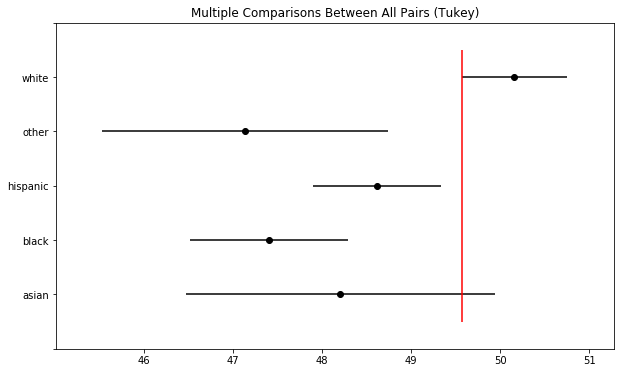

In [33]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=voter_age, #Data
                         groups=voter_race, #Groups
                         alpha=0.05) #Significance level

tukey.plot_simultaneous() # Plot group confidence intervals
plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red") 

tukey.summary()

The test result suggests we reject the null hypothesis for 3 pairs, with each pair indlucing the "white" category. This suggests that the white group is likely diferent from the others. The 95% confidence interval plot reinforces the results visually - there is asian group's confidence interval overlaps the white group's confidence interval